<a href="https://colab.research.google.com/github/edcalderin/Competencia_Puntaje_Recencia/blob/master/Competencia_Puntaje_Recencia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predecir el Puntaje de Recencia en Papers de Investigación
*Notebook created by Erick Calderin*

**Web site:** https://www.datasource.ai/es/home/data-science-competitions-for-startups/predecir-el-puntaje-de-recencia-en-papers-de-investigacion

## Modules

In [1]:
# Utilities

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# For ML
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import multiprocessing as mp

For NLP

In [3]:
# Install
!pip install -U spacy
!python -m spacy download en_core_web_sm
!python -m spacy download es_core_news_sm
!python -m spacy download pt_core_news_sm

2021-08-11 03:46:12.756817: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
     |████████████████████████████████| 13.6 MB 66 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
2021-08-11 03:46:26.843972: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
     |████████████████████████████████| 13.7 MB 104 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
2021-08-11 03:46:35.515000: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
     |████████████████████████████████| 21.9 MB 115 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


In [4]:
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer

## Importing data

Getting training and test datasets from Drive.

In [5]:
# Train
PREFIX = '/content/drive/MyDrive/Colab Notebooks/CompetenciaPuntajeRecencia'
train = pd.read_csv(PREFIX+'/Train.csv')
test = pd.read_csv(PREFIX+'/Test.csv')

## Exploring

In [6]:
train.head()

,id,Language,Year,Abstract,Title,total_rel_score
0,1,en,2016,The present study investigates an inventory mo...,Replenishment policy for non-instantaneous det...,0.630682
1,2,en,2019,AIM: To investigate the clinical characteristi...,Analysis of soldiers' orbital wall fracture su...,0.583333
2,3,en,2019,"Aflatoxin M1 (AFM1) and ochratoxin A (OTA), wh...","Modulation of Mucin (MUC2, MUC5AC and MUC5B) m...",0.372222
3,4,en,2017,Background/Aim: There are still unrevealed tre...,Traditional dentistry knowledge among Serbs in...,0.661765
4,5,en,2015,Impairment in empathy has been demonstrated in...,Dimensional schizotypy and social cognition: A...,0.373737


In [7]:
print('Train Shape', train.shape)
print('Test Shape', test.shape)

Train Shape (21456, 6)
Test Shape (10728, 5)


In [8]:
print('Unique languages\n', train.Language.value_counts())
print('\nAmount Unique Years', len(train.Year.value_counts()))

Unique languages
 en    18539
pt     1539
es     1378
Name: Language, dtype: int64

Amount Unique Years 59


No missing values!

In [9]:
train.isna().sum()

id                 0
Language           0
Year               0
Abstract           0
Title              0
total_rel_score    0
dtype: int64

Score distribution for each language

Text(0.5, 6.79999999999999, 'Scores')

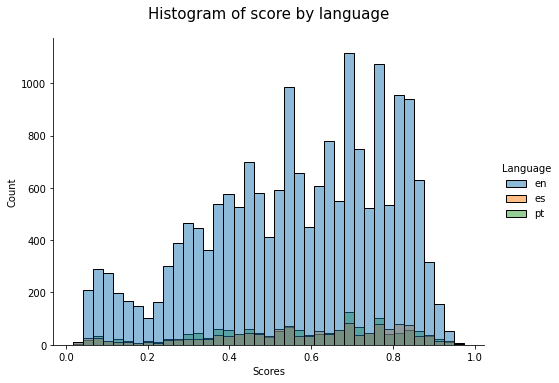

In [10]:
sns.displot(data=train, x= 'total_rel_score', aspect=1.4, hue='Language')
plt.title('Histogram of score by language', fontsize=15, pad=20)
plt.xlabel('Scores')

Plot above indicate us there is no outliers within data, another great new! However we can notice that papers at english language overcome to ones created in other languages.

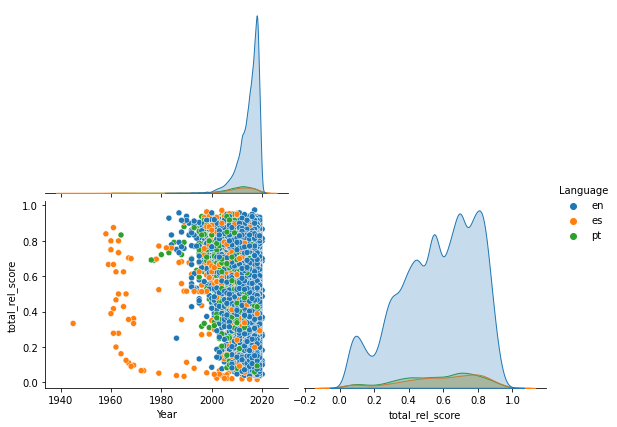

In [11]:
sns.pairplot(train.drop(columns=['id']), hue='Language', corner=True, aspect=1.3, height=3)

In another hand, there is a clear separation between papers at spanish language in early years and rest of papers.

## Preprocessing

### Creating dummy variables for Language

In [12]:
dummy_language = OneHotEncoder(dtype='int8')
df_dummy_language = dummy_language.fit_transform(train[['Language']]).toarray()

In [13]:
train = train.join(pd.DataFrame(df_dummy_language, columns=dummy_language.categories_[0]))

### MinMaxScaler to Year

In [14]:
minMaxScaler = MinMaxScaler()
year_minmax = minMaxScaler.fit_transform(train[['Year']])
train.Year = year_minmax

In [15]:
train.head()

,id,Language,Year,Abstract,Title,total_rel_score,en,es,pt
0,1,en,0.946667,The present study investigates an inventory mo...,Replenishment policy for non-instantaneous det...,0.630682,1,0,0
1,2,en,0.986667,AIM: To investigate the clinical characteristi...,Analysis of soldiers' orbital wall fracture su...,0.583333,1,0,0
2,3,en,0.986667,"Aflatoxin M1 (AFM1) and ochratoxin A (OTA), wh...","Modulation of Mucin (MUC2, MUC5AC and MUC5B) m...",0.372222,1,0,0
3,4,en,0.960000,Background/Aim: There are still unrevealed tre...,Traditional dentistry knowledge among Serbs in...,0.661765,1,0,0
4,5,en,0.933333,Impairment in empathy has been demonstrated in...,Dimensional schizotypy and social cognition: A...,0.373737,1,0,0


### Applying NLP

##### Tokenizing

In [16]:
# Loading spacy for every target language
nlp_en = spacy.load('en_core_web_sm')
nlp_es = spacy.load('es_core_news_sm')
nlp_pt = spacy.load('pt_core_news_sm')

In [17]:
# Function for lemmatization, filtering stopword and length of words

def get_tokens(dataframe):
    '''
    dataframe: Pandas Dataframe with two columns 'Abstract' and 'Language'
    '''
    tokens_doc = []
    for item in tqdm(dataframe.itertuples()):
        text = item.Abstract
        src_lang = item.Language
        # Create nlp object according to language
        if src_lang=='en':
            nlp_lang = nlp_en(text)
        elif src_lang=='es':
            nlp_lang = nlp_es(text)
        else:
            nlp_lang = nlp_pt(text)

        # Filtering 
        tokens = [word.lemma_ for word in nlp_lang 
                  if word.pos_ not in ['PUNCT', 'SPACE', 'NUM']
                  and not word.is_stop      
                  and len(word)>2            
                ]
        tokens_doc.append(' '.join(tokens))
    return tokens_doc

In [18]:
%%time
train['Abstract_tokens'] = get_tokens(train[['Abstract', 'Language']])


CPU times: user 15min 31s, sys: 10.6 s, total: 15min 42s
Wall time: 15min 42s


In [20]:
train[['Abstract', 'Abstract_tokens']].head()

,Abstract,Abstract_tokens
0,The present study investigates an inventory mo...,present study investigate inventory model non ...
1,AIM: To investigate the clinical characteristi...,AIM investigate clinical characteristic surgic...
2,"Aflatoxin M1 (AFM1) and ochratoxin A (OTA), wh...",Aflatoxin AFM1 ochratoxin OTA widely coexist m...
3,Background/Aim: There are still unrevealed tre...,background Aim unreveale treasure traditional ...
4,Impairment in empathy has been demonstrated in...,impairment empathy demonstrate patient schizop...


##### Vectorization

In [37]:
vectorizer_model = TfidfVectorizer(min_df=40, encoding='ascii')
vectorizer_values = vectorizer_model.fit_transform(train['Abstract_tokens'])

In [38]:
train_with_tfidf = train.join(pd.DataFrame(vectorizer_values.toarray(), 
                        columns=vectorizer_model.get_feature_names())
        )

### Dropping unnecessary columns:

In [39]:
COLS = ['id', 'Abstract', 'Title', 'Language', 'Abstract_tokens']
train_with_tfidf.drop(COLS, axis=1, inplace=True)

In [40]:
train_with_tfidf.head()

,Year,total_rel_score,en,es,pt,000,0001,001,01,02,03,04,05,10,100,11,12,13,14,15,16,17,18,19,1990,19th,1department,1st,1β,20,2000,2003,2004,2005,2008,20th,21,21st,22,23,...,work,worker,working,workplace,workshop,world,worldwide,worsen,wound,write,writer,writing,wt,www,xrd,yang,year,years,yeast,yellow,yield,yl,young,youth,zealand,zinc,zona,zone,ácido,água,ámbito,área,âmbito,él,época,ético,índice,último,único,útil
0,0.946667,0.630682,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.986667,0.583333,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.072131,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.034675,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.031222,0.0,0.0,0.0,0.0,0.0,0.051022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.986667,0.372222,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.960000,0.661765,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.933333,0.373737,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.112786,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Training

In [41]:
X = train_with_tfidf.drop(['total_rel_score'], axis=1)
y = train_with_tfidf.total_rel_score

In [42]:
SEED = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED, shuffle=True)

In [43]:
%%time
model = BayesianRidge(n_iter=50, verbose=True)
model.fit(X_train, y_train)

Convergence after  21  iterations
CPU times: user 17min 31s, sys: 20.8 s, total: 17min 51s
Wall time: 9min 9s


In [44]:
def results_metric(model):
    # Predict for train and test
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # RMSLE metric
    rmsle_train = np.sqrt(mean_squared_log_error(y_train, y_pred_train))
    rmsle_test = np.sqrt(mean_squared_log_error(y_test, y_pred_test))

    # Plotting results
    plt.figure(figsize=(12, 5))
    sns.set(color_codes=True)
    plt.subplot(1, 2, 1)    
    sns.histplot(y_train - y_pred_train, bins=20, kde=True, color='g')
    sns.histplot(y_test - y_pred_test, bins=20, kde=True, color='r')
    plt.legend(['Train','Test'])
    plt.subplot(1, 2, 2)
    sns.scatterplot(x=y_test, y=y_pred_test)
    sns.set(None)
    lims = [
        np.min([plt.xlim(), plt.ylim()]),  # min of both axes
        np.max([plt.xlim(), plt.ylim()]),  # max of both axes]
    ]

    plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('Y Test')
    plt.ylabel('Y Pred Test')
    print('RMSLE Train', rmsle_train)
    print('RMSLE Test', rmsle_test)

RMSLE Train 0.12628751989103762
RMSLE Test 0.13596479573559916


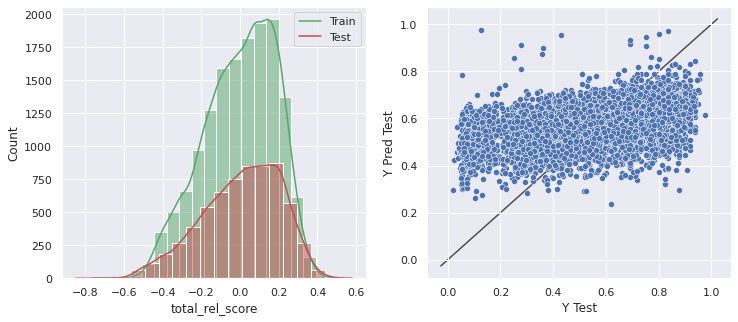

In [45]:
results_metric(model)

## Predictions

Preprocessing Test dataset

In [46]:
# Creating dummy variables from OneHotEncoder created previosly...
dummy_test = dummy_language.transform(test[['Language']]).toarray()

# Converting to Dataframe with named columns for dummy
dummy_test = pd.DataFrame(dummy_test, columns=dummy_language.categories_[0])

# Scaling Year
test.Year = minMaxScaler.transform(test[['Year']])

# Joining dummy columns to full test dataset
test = test.join(dummy_test)

Saving Id column for submission csv file:

In [47]:
id = test.id

Applying NLP

In [48]:
%%time
test['Abstract_tokens'] = get_tokens(test[['Abstract','Language']])


CPU times: user 7min 42s, sys: 5.52 s, total: 7min 47s
Wall time: 7min 47s


In [49]:
vectorizer_values_test = vectorizer_model.transform(test['Abstract_tokens'])
test_with_tfidf = test.join(pd.DataFrame(vectorizer_values_test.toarray(), 
                        columns=vectorizer_model.get_feature_names())
        )

Removing same columns as train dataset:

In [50]:
test_with_tfidf.drop(COLS, axis=1, inplace=True)

In [51]:
test_with_tfidf.head()

,Year,en,es,pt,000,0001,001,01,02,03,04,05,10,100,11,12,13,14,15,16,17,18,19,1990,19th,1department,1st,1β,20,2000,2003,2004,2005,2008,20th,21,21st,22,23,24,...,work,worker,working,workplace,workshop,world,worldwide,worsen,wound,write,writer,writing,wt,www,xrd,yang,year,years,yeast,yellow,yield,yl,young,youth,zealand,zinc,zona,zone,ácido,água,ámbito,área,âmbito,él,época,ético,índice,último,único,útil
0,0.933333,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.059126,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.906667,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.866667,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.04648,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.813333,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.092682,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.973333,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.025516,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
y_pred = model.predict(test_with_tfidf)
predictions = pd.DataFrame({'id':id, 'total_rel_score':y_pred})
predictions.head()

,id,total_rel_score
0,1,0.600071
1,2,0.595364
2,3,0.660612
3,4,0.577673
4,5,0.614061


In [53]:
predictions.to_csv(PREFIX+'/SampleSubmission.csv', index=False)